In [1]:
# print out each line in the input cell not only the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# expand the cell width to 100% of t 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# Jupyter-Notebook mit Python Implementierungen für Julia Mengen
---
*Erstellt von: Simon Gärtner*

Folgendes Notebook gilt als Ergänzung zum Notebook "Julia Mengen". Hier werden die erwähnten Python- und Python-Numba-Implementierungen implementiert. Leider ist hierfür ein extra Notebook notwendig, da dieses auf einem Python-Kernel laufen muss.

**Bitte führen Sie vor dem Start dieses Notebooks folgende Installierungsbefehle durch:**

`sudo pip install numpy`

`sudo pip install mathplotlib`

`sudo pip install numba`

## Allgemeine Methoden für Python und Python-Numba Implementierung:
---

In diesem Abschnitt sind alle Methoden definiert, die beide Implementierungen verwedenden.
1. Import-Befehle
2. Analytics Klasse zur Berechnung der Anzahl an Multiplikationen und Additionen
3. Methode zum initialisieren des Setups für Julia Mengen (*Für eine genauere Beschreibung der einzelnen Parameter siehe im anderen Notebook bei der namensgleichen Methode*)

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List 

In [3]:
# analytics class to define class variables for multiplications and additions
class Analytics:
    multiplications = 0
    additions = 0

In [4]:
def initialize_julia_sets(constant_c, formula, x_start, x_end, y_start, y_end, scaling):
    """
    Initializes the parameters for generating Julia sets.

    Args:
        constant_c (complex): The constant value used in the Julia set formula.
        formula (str): The formula used for generating the Julia set.
        x_start (float): The starting value for the x-axis range.
        x_end (float): The ending value for the x-axis range.
        y_start (float): The starting value for the y-axis range.
        y_end (float): The ending value for the y-axis range.
        scaling (int): The scaling factor used for incrementing the values.

    Returns:
        dict: A dictionary containing the initialized parameters for generating Julia sets.
            - 'constant_c': The constant value used in the Julia set formula.
            - 'formula': The formula used for generating the Julia set.
            - 'x_start': The starting value for the x-axis range.
            - 'x_end': The ending value for the x-axis range.
            - 'y_start': The starting value for the y-axis range.
            - 'y_end': The ending value for the y-axis range.
            - 'scaling': The scaling factor used for incrementing the values.
    """
    return {
        'constant_c': constant_c,
        'formula': formula,
        'x_start': x_start,
        'x_end': x_end,
        'y_start': y_start,
        'y_end': y_end,
        'scaling': scaling
    }

## Methoden für Python-Implementierung:
---
In folgendem Abschnitt sind alle spezifischen Methoden für die Python Implementierung programmiert. Der Algorithmus ist dabei stark an die SageMath Implementierung angelehnt. Allerdings wurde hier auf SageMath spezifische Befehle verzichtet und durch reine Python-Funktionen ersetzt.
1. Initialisiert die Matrix mit den Startwerten für die Folge
2. Ein übergebener Startwert wird für die Folge ausgewertet und geprüft, ob dieses berschränkt oder unbeschränkt ist.
3. Diese Methode wertet die Konvergenz für jeden komplexen Punkt aus der Ebenen aus. Hierfür wird die Methode `alidate_point_python(complex_number, constant_c)` genutzt.

In [5]:
def initialize_matrix_python(setup):
    """
    Initializes a matrix using the provided setup parameters.

    Args:
        setup (dict): A dictionary containing the setup parameters for matrix initialization.

    Returns:
        Matrix: The initialized matrix.

    """
    matrix_list = []

    for col in np.arange(setup['x_start'], setup['x_end'] + 1, 1 / setup['scaling']):
        col_list = []

        for row in np.arange(setup['y_start'], setup['y_end'] + 1, 1 / setup['scaling']):
            col_list.append(row + (col * -1) * 1j)
        matrix_list.append(col_list)

    return matrix_list

In [6]:
def validate_point_python(complex_number, constant_c):
    """
    Validates a complex number using the given constant_c.

    Args:
        complex_number (complex): The initial complex number to be validated.
        constant_c (complex): The constant complex number.

    Returns:
        int: The number of iterations until the complex number exceeds the validation bounds or the maximum number of iterations is reached.

    """
    run = 200

    while -100 < complex_number.real < 100 and run > 0:
        complex_number = complex_number * complex_number + constant_c
        Analytics.multiplications += 1
        Analytics.additions += 1
        run -= 1

    return run

In [7]:
def change_matrix_python(matrix_complex_numbers, x_start, x_end, y_start, y_end, constant, matrix_scaling):
    """
    Changes the matrix of complex numbers using the given constant and scaling.

    Args:
        matrix_complex_numbers (list): The matrix of complex numbers to be modified.
        x_start (float): The starting value of the x-axis.
        x_end (float): The ending value of the x-axis.
        y_start (float): The starting value of the y-axis.
        y_end (float): The ending value of the y-axis.
        constant (complex): The constant complex number.
        matrix_scaling (int): The scaling factor for the matrix.

    Returns:
        list: The modified matrix.

    """
    final_matrix = []

    for row in range((y_end - y_start) * matrix_scaling + 1):
        rows = []
        for col in range((x_end - x_start) * matrix_scaling + 1):
            rows.append(validate_point_python(matrix_complex_numbers[row][col], constant))
        final_matrix.append(rows)

    return final_matrix

## Methoden für Python-Numba Implementierung:
---
Folgende Methoden sind spezifisch für die Python-Numba Implementierung. Sie erfüllen die gleichen Funktionen, wie die obigen Methoden unter dem Punkt "Methoden für Python Implementierung". 

Sie wurden nur um die Kennzeichnung `@njit` erweitert. Diese Kennzeichnung sorgt dafür, dass diese Methode erst nach C, C++ oder Fortan übersetzt wird und anschließend erst zu Maschinencode compiliert wird.

Weitere Änderungen gab es z.B. in der Parameterübergabe oder in der Abspeicherung. Dies hängt damit zusammen, da Numba nicht mit allen Python-Konstrukten zurecht kommt. Daher wurden diese durch möglich Konstrute ausgetauscht, bzw. abgeändert. (Dokumentation von Numba: https://numba.pydata.org/numba-doc/dev/reference/pysupported.html)

In [8]:
@njit
def initialize_matrix(x_start, x_end, y_start, y_end, scaling):
    """
    Initializes a matrix using the provided setup parameters.

    Args:
        x_start (float): The starting value of the x-axis.
        x_end (float): The ending value of the x-axis.
        y_start (float): The starting value of the y-axis.
        y_end (float): The ending value of the y-axis.
        matrix_scaling (int): The scaling factor for the matrix.
        
    Returns:
        Matrix: The initialized matrix.

    """
    matrix_list = List()

    for col in np.arange(x_start, x_end + 1, 1 / scaling):
        col_list = List()

        for row in np.arange(y_start, y_end + 1, 1 / scaling):
            col_list.append(row + (col * -1) * 1j)
        matrix_list.append(col_list)

    return matrix_list

In [9]:
@njit
def validate_point(complex_number, constant_c):
    """
    Validates a complex number using the given constant_c.

    Args:
        complex_number (complex): The initial complex number to be validated.
        constant_c (complex): The constant complex number.

    Returns:
        int: The number of iterations until the complex number exceeds the validation bounds or the maximum number of iterations is reached.

    """
    run = 200

    while -100 < complex_number.real < 100 and run > 0:
        complex_number = complex_number * complex_number + constant_c
        run -= 1

    return run

In [10]:
@njit
def change_matrix(matrix_complex_numbers, x_start, x_end, y_start, y_end, constant, matrix_scaling):
    """
    Changes the matrix of complex numbers using the given constant and scaling.

    Args:
        matrix_complex_numbers (list): The matrix of complex numbers to be modified.
        x_start (float): The starting value of the x-axis.
        x_end (float): The ending value of the x-axis.
        y_start (float): The starting value of the y-axis.
        y_end (float): The ending value of the y-axis.
        constant (complex): The constant complex number.
        matrix_scaling (int): The scaling factor for the matrix.

    Returns:
        list: The modified matrix.

    """
    final_matrix = []

    for row in range((y_end - y_start) * matrix_scaling + 1):
        rows = []
        for col in range((x_end - x_start) * matrix_scaling + 1):
            rows.append(validate_point(matrix_complex_numbers[row][col], constant))
        final_matrix.append(rows)

    return final_matrix

## Bild-Generator:
---

Folgende Methode generiert das Bild einer Julia Menge und konfiguiert dies mit den richtigen Eigenschaften.

In [11]:
def create_picture(final_matrix):
    """
    Creates and displays a picture using the final matrix.

    Args:
        final_matrix: The matrix representing the picture.

    """
    plt.figure(figsize=(2, 2), dpi=800)
    plt.imshow(final_matrix)
    plt.axis('off')
    plt.axis('tight')
    plt.set_cmap('seismic')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.show()

## Start Python-Numba Implementierung:
---

*Hinweis: Die Ausgabe der Anzahl von Multiplikationen und Additionen funktioniert für diese Implementierung nicht, da Numba nicht mit Klassen umgehen kann. Daher wird hier eine 0 ausgegeben.*

Folgender Codeblock startet die Python-Numba Implementierung. Neben der Julia-Mengen Grafik werden auch verschiedene Analysen zur Laufzeit ausgegeben.

Initialize setup...
Initialize done: 0.0 seconds!
Initialize Matrix...
Initialize done: 2.72 seconds!
Calculating....
Calculation done: 12.26 seconds!


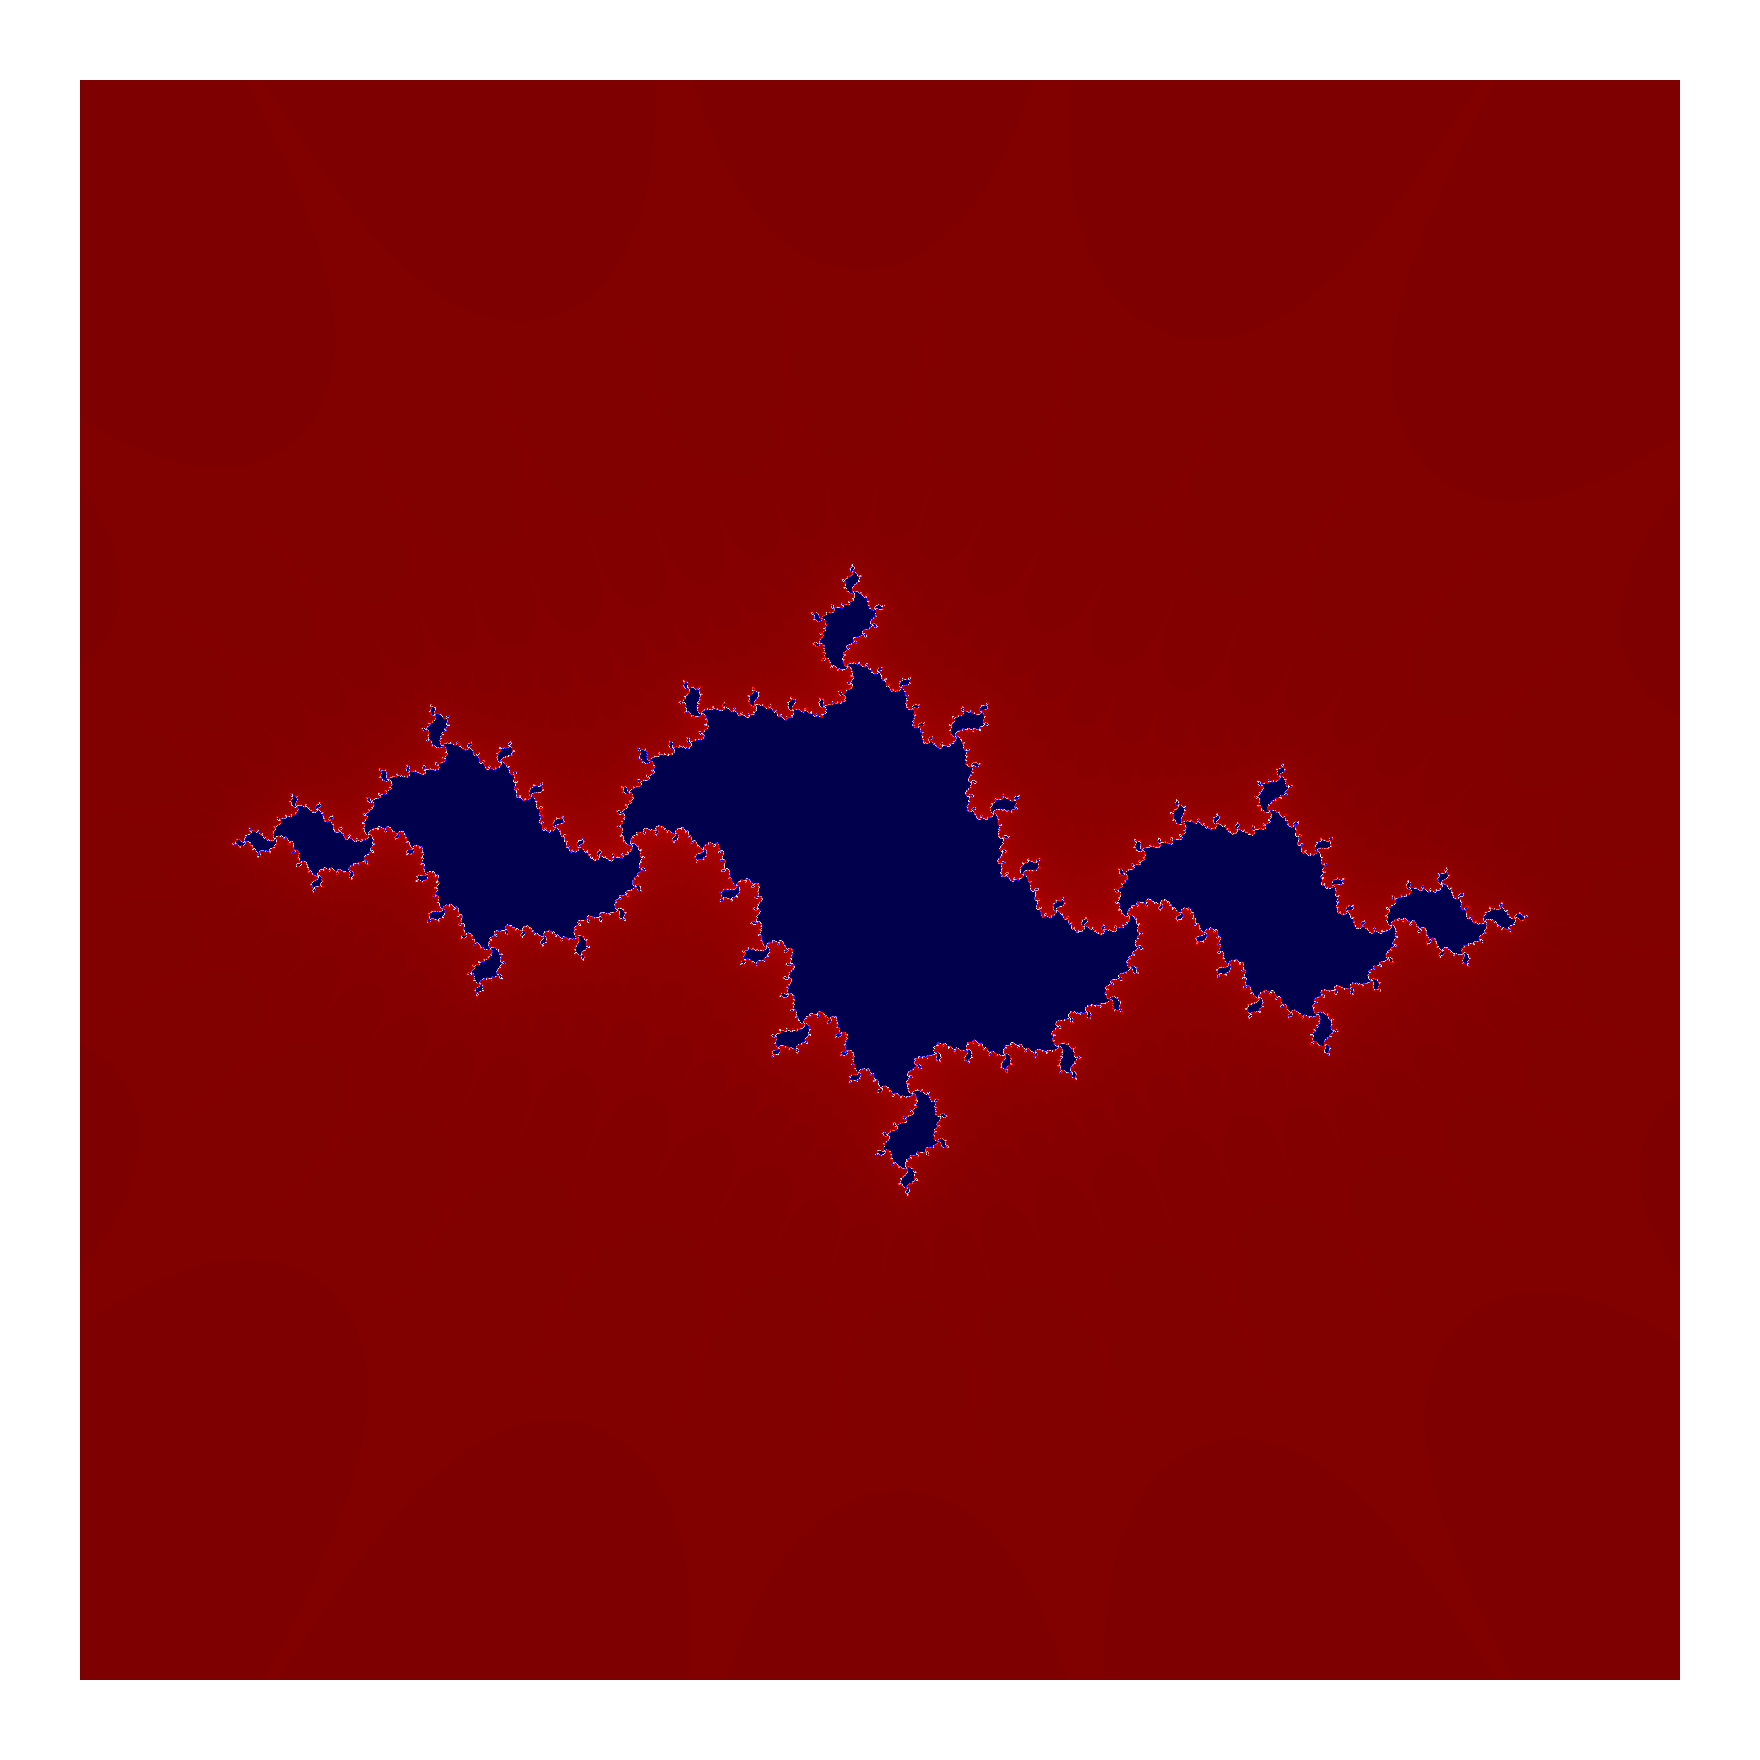

Overall time: 14.98 seconds!
Amount of multiplications: 0
Amount of aditions: 0


In [14]:
t2 = time.time()
Analytics.multiplications = 0
Analytics.additions = 0

print('Initialize setup...')

t0 = time.time()

# Initialize setup parameters
setup = initialize_julia_sets(complex(-1, 0.2), 'x^2+c', -2, 2, -2, 2, 2000)
func = setup['formula']

t1 = time.time()

print('Initialize done: ' + str(round(t1 - t0, 2)) + ' seconds!')

print('Initialize Matrix...')

t0 = time.time()

# Initialize matrix
matrix = initialize_matrix(setup['x_start'], setup['x_end'], setup['y_start'], setup['y_end'], setup['scaling'])

t1 = time.time()

print('Initialize done: ' + str(round(t1 - t0, 2)) + ' seconds!')

print('Calculating....')
t0 = time.time()

# Change matrix values
matrix = change_matrix(matrix, setup['x_start'], setup['x_end'], setup['y_start'], setup['y_end'], setup['constant_c'], setup['scaling'])

t1 = time.time()

print('Calculation done: ' + str(round(t1 - t0, 2)) + ' seconds!')

t3 = time.time()

create_picture(matrix)

print('Overall time: ' + str(round(t3 - t2, 2)) + ' seconds!')
print('Amount of multiplications: ' + str(Analytics.multiplications))
print('Amount of aditions: ' + str(Analytics.additions))

## Start Python Implementierung:
---

Folgender Codeblock startet die Python Implementierung. Neben der Julia Mengen Grafik werden auch weitere Analysen ausgegeben, wie z.B. benötigte Zeit oder die Anzahl an Multiplikationen bzw. Additionen.

Initialize setup...
Initialize done: 0.0 seconds!
Initialize Matrix...
Initialize done: 1.29 seconds!


/usr/local/lib/python3.10/dist-packages/numba/typed/typedlist.py:82: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'item' of function 'impl_append.<locals>.impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../usr/local/lib/python3.10/dist-packages/numba/typed/listobject.py", line 599:

    def impl(l, item):
    ^

  l.append(item)
/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'item' of function '_append'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../usr/local/lib/python3.10/dist-packages/numba/typed/typedlist.py

Calculating....
Calculation done: 5.78 seconds!


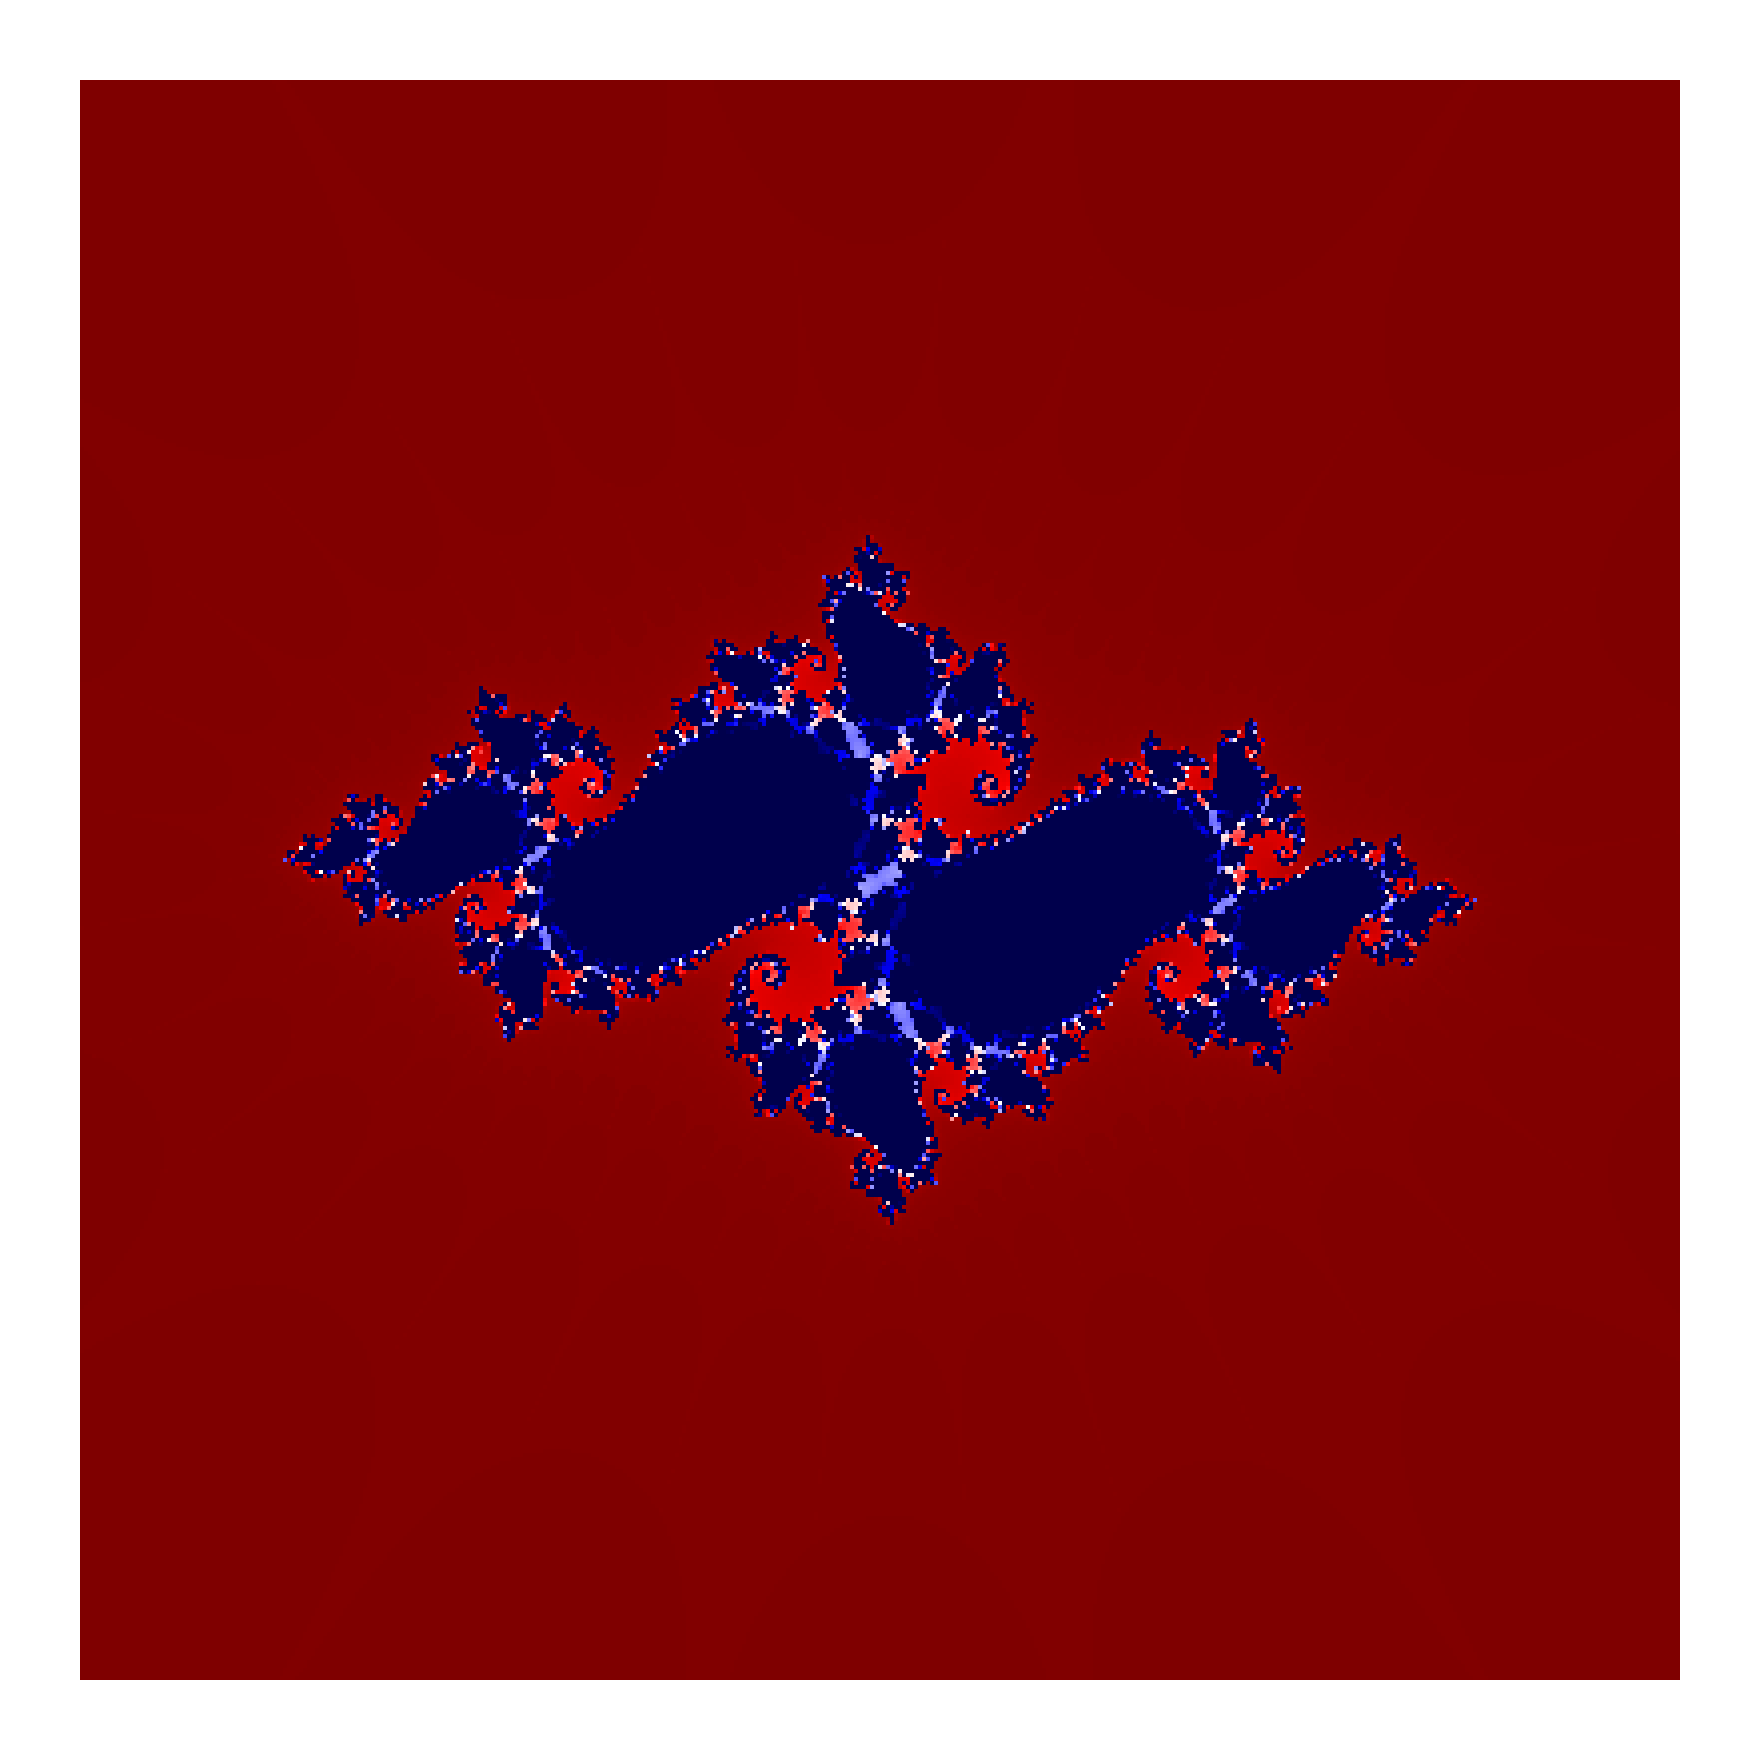

Overall time: 8.04 seconds!
Amount of multiplications: 4179391
Amount of aditions: 4179391


In [13]:
t2 = time.time()

print('Initialize setup...')
Analytics.multiplications = 0
Analytics.additions = 0

t0 = time.time()


# Initialize setup parameters
setup = initialize_julia_sets(complex(-0.7423, 0.105), 'x^2+c', -2, 2, -2, 2, 100)
func = setup['formula']

t1 = time.time()

print('Initialize done: ' + str(round(t1 - t0, 2)) + ' seconds!')

print('Initialize Matrix...')

t0 = time.time()

# Initialize matrix
matrix = initialize_matrix_python(setup)

t1 = time.time()

print('Initialize done: ' + str(round(t1 - t0, 2)) + ' seconds!')

converter_list = List()

for index in matrix:
    converter_list.append(index)

print('Calculating....')

t0 = time.time()

# Change matrix values
matrix = change_matrix_python(converter_list, setup['x_start'], setup['x_end'], setup['y_start'], setup['y_end'], setup['constant_c'], setup['scaling'])

t1 = time.time()

print('Calculation done: ' + str(round(t1 - t0, 2)) + ' seconds!')

t3 = time.time()

create_picture(matrix)

print('Overall time: ' + str(round(t3 - t2, 2)) + ' seconds!')
print('Amount of multiplications: ' + str(Analytics.multiplications))
print('Amount of aditions: ' + str(Analytics.additions))

## Auswertung der Algorithmen
---
Für die Auswertung der Algorithmen schauen Sie bitte im Hauptnotebook - Jula Mengen - nach.